In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import import_data
import preprocessing
import feature_extraction
import dimension_reduction
import classification
import matplotlib 
import os

test_size = 0.2
random_state = 104

[nltk_data] Downloading package wordnet to /home/makus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/makus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


needed to create pgf datas for including in the paper

In [2]:
os.chdir('/home/makus/Documents/Semester_7_WIN2022/Bachelorarbeit/bachelor-thesis/img/')

# load data

In [3]:
spam_assasin = import_data.create_df_spam_assasin('/home/makus/Documents/Semester_7_WIN2022/Bachelorerbeit/ba_code/datasets/spamassasin/')
spam_assasin

,text,label
index,,
0,From fork-admin@xent.com Mon Sep 30 17:56:37 ...,0
1,From rssfeeds@jmason.org Tue Oct 1 10:37:07 ...,0
2,From rpm-list-admin@freshrpms.net Tue Oct 8 ...,0
3,From pudge@perl.org Tue Oct 1 10:34:35 2002\...,0
4,From fork-admin@xent.com Tue Sep 10 11:07:41 ...,0
...,...,...
4694,From fork-admin@xent.com Mon Jul 29 20:27:37 ...,1
4695,From honey9531@btamail.net.cn Mon Jun 24 17:0...,1
4696,From gintare@netzero.net Mon Jun 24 17:43:43 ...,1


# feature extraction + dimension reduction

In [4]:
y = spam_assasin['label']
mails = spam_assasin['text']

tfidf_mails = feature_extraction.tfidf_vectorize(mails)
sparse_mails = dimension_reduction.sparse_random_projection(tfidf_mails)
ipca_mails = dimension_reduction.ipca(sparse_mails, 100)
X = ipca_mails
del mails, tfidf_mails, sparse_mails, ipca_mails, spam_assasin

X.shape

It took 3.39139870100189 second(s) to finish TF-IDF feature extraction.
It took 8.05070783800329 second(s) to finish dimension reduction with Sparse Random Projection.
It took 27.61233230200014 second(s) to finish dimension reduction with IPCA.


(4699, 100)

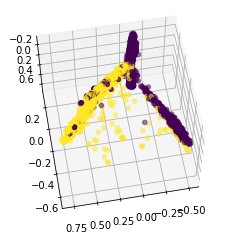

In [25]:
xs = X[:,0]
ys = X[:,1]
zs = X[:,2]
colors = y

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs, c=colors, alpha = 0.5)
ax.view_init(-120,100)
plt.savefig('assasin_graph.pdf')
plt.show()

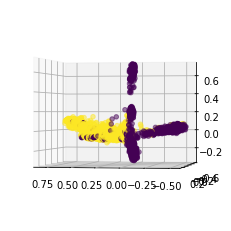

In [29]:
xs = X[:,0]
ys = X[:,1]
zs = X[:,2]
colors = y

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs, c=colors, alpha = 0.5)
ax.view_init(0,100)
plt.savefig('assasin_graph_two.pdf')
plt.show()

# Reference SVM classification

In [6]:
reference_report, X_test, y_test, y_pred = classification.svm(X,y,test_size, random_state)

reference_report

SVM model fitted in 1.5125399530079449 second(s)
SVM predicted the testset in 0.2009478349937126 second(s)


,0,1,accuracy,macro avg,weighted avg
precision,0.974619,0.951289,0.965957,0.962954,0.966007
recall,0.971332,0.956772,0.965957,0.964052,0.965957
f1-score,0.972973,0.954023,0.965957,0.963498,0.965978
support,593.000000,347.000000,0.965957,940.000000,940.000000


this is our reference svm for the comparison

Got 32 classificaton mistakes


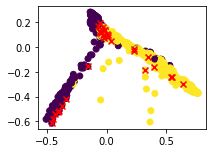

In [7]:
x_wrong = X_test[y_test != y_pred]
print("Got %d classificaton mistakes" % len(x_wrong))

fig, ax = plt.subplots(figsize=(3,2.25))
ax.scatter(X_test[:,0], X_test[:,1], c=y_pred, marker="o")
ax.scatter(x_wrong[:,0], x_wrong[:,1], color='red', marker="x")
plt.show()

# K-Means + Elbow plot

Now we create our elbow graph. A cluster count above 25 has not much sense

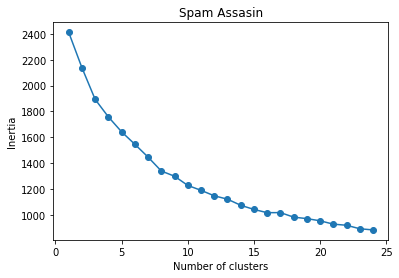

In [8]:
max_cluster = 25
inertias = classification.elbow_inertias_list(X,max_cluster)

plt.figure()
plt.plot(range(1,max_cluster), inertias, marker='o')
plt.title('Spam Assasin')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.savefig('asassin_elbow_high_dim.pdf')
plt.show() 

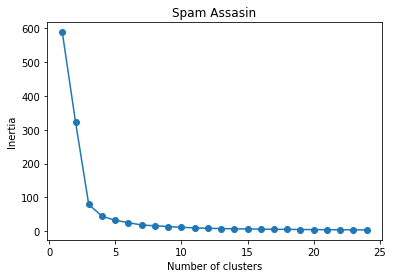

In [9]:
max_cluster = 25
inertias = classification.elbow_inertias_list(X[:,:2],max_cluster)

plt.figure()
plt.plot(range(1,max_cluster), inertias, marker='o')
plt.title('Spam Assasin')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.savefig('asassin_elbow_two_dim.pdf')
plt.show() 

# SVM and K-Means merging hypothesis

Now we test our hypothesis, wether replacing the original labels with k-means generated labels can improve a svm classification

In [10]:
report, X_test, y_test, y_pred = classification.svm_merging_hypothesis(2,X,y)
report

It took 16.307919040991692 second(s) to search the best k-means clustering for merging hypothesis
It took 16.551787891992717 second(s) to complete the svm classification combined with k-means - merging hypothesis


,0,1,accuracy,macro avg,weighted avg
precision,0.745358,0.833333,0.762766,0.789346,0.777834
recall,0.947723,0.446686,0.762766,0.697205,0.762766
f1-score,0.834447,0.581614,0.762766,0.708030,0.741114
support,593.000000,347.000000,0.762766,940.000000,940.000000


k-means with the original cluster count does not improve the classification

Got 223 classificaton mistakes


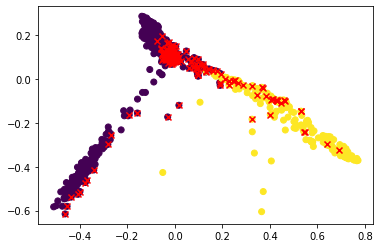

In [11]:
x_wrong = X_test[y_test != y_pred]
print("Got %d classificaton mistakes" % len(x_wrong))

fig, ax = plt.subplots()
ax.scatter(X_test[:,0], X_test[:,1], c=y_pred, marker="o")
ax.scatter(x_wrong[:,0], x_wrong[:,1], color='red', marker="x")
plt.show()

Now we estimate a good cluster count based on the elbow-graph

In [12]:
report, X_test, y_test, y_pred = classification.svm_merging_hypothesis(4,X,y)
report

It took 20.277276724998956 second(s) to search the best k-means clustering for merging hypothesis
It took 20.492310018002172 second(s) to complete the svm classification combined with k-means - merging hypothesis


,0,1,accuracy,macro avg,weighted avg
precision,0.744371,0.832432,0.761702,0.788402,0.776879
recall,0.947723,0.443804,0.761702,0.695764,0.761702
f1-score,0.833828,0.578947,0.761702,0.706388,0.739739
support,593.000000,347.000000,0.761702,940.000000,940.000000


Got 224 classificaton mistakes


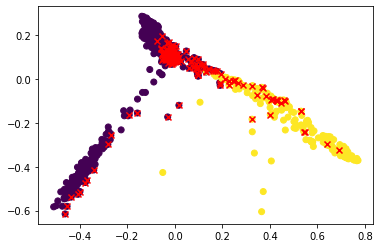

In [13]:
x_wrong = X_test[y_test != y_pred]
print("Got %d classificaton mistakes" % len(x_wrong))

fig, ax = plt.subplots()
ax.scatter(X_test[:,0], X_test[:,1], c=y_pred, marker="o")
ax.scatter(x_wrong[:,0], x_wrong[:,1], color='red', marker="x")
plt.show()

For increasing the number of clusters, the classification is getting worse.
The classification results are worse than the normal SVM
 
-> Merging is not a good approach

# Adding K-means clustering as new feature

we add now the k-means clustering result as a new column in our dataset and then classify the data with a svm. -> Test this approach with cluster count between 2 and 25

In [16]:
reference_report

,0,1,accuracy,macro avg,weighted avg
precision,0.974619,0.951289,0.965957,0.962954,0.966007
recall,0.971332,0.956772,0.965957,0.964052,0.965957
f1-score,0.972973,0.954023,0.965957,0.963498,0.965978
support,593.000000,347.000000,0.965957,940.000000,940.000000


In [17]:
report = classification.k_means_cluster_search(X,y,25)
report

,Number_of_clusters,Accuracy,F_one_Score,Time
0,2.0,0.963830,0.971332,2.259132
1,3.0,0.962766,0.970514,2.511205
2,4.0,0.831915,0.860177,2.782098
3,5.0,0.732979,0.769089,3.122099
4,6.0,0.536170,0.594796,2.996047
5,7.0,0.611702,0.683435,3.457913
6,8.0,0.619149,0.687609,3.399370
7,9.0,0.460638,0.550133,3.997307
8,10.0,0.563830,0.663934,4.107810
9,11.0,0.508511,0.603774,4.314949


3 means improves the performance of the classification

# Combine both approaches

Add the merging approach as a new feature vector to the dataset and then classify with svm.


In [18]:
report = classification.k_means_cluster_search_merging_hypothesis(X,y,4)
report

It took 21.759014586001285 second(s) to search the best k-means clustering for merging hypothesis


,Accuracy,F_one_Score,Time
0,0.96383,0.971332,22.697914


It is very computation heavy even on a small dataset. So even a slightly improve is not worth.
